In [57]:
from itertools import count

import matplotlib.patches as mpatches
import matplotlib.path as mpath
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
from PIL import Image
import io

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length

import IPython.display

In [2]:
n_inliers = 1 << 16
n_outliers = 1 << 4
rng = np.random.default_rng(0)


def generate_inliers(n, rng):
    return rng.uniform([0, 0], [0.5, 0.5], (n, 2))


def generate_outliers(n, rng, loc=[1, 1]):
    return rng.normal(loc, 0.1, (n, 2))


x = np.concatenate([generate_inliers(n_inliers, rng),
                    generate_outliers(n_outliers, rng, [1, 1]),
                    generate_outliers(n_outliers, rng, [0, 1]),
                    generate_outliers(n_outliers, rng, [1, 0])])
x_labels = np.concatenate([np.ones(n_inliers), -np.ones(3 * n_outliers)])

In [65]:
class AnomalyDetector:
    def __init__(self, title):
        self.title = title
        self.known_data = None
        self.known_labels = None
    
    def train(self, data):
        raise NotImplementedError('abstract method called')
    
    def score(self, data):
        raise NotImplementedError('abstract method called')
    
    def observe(self, point, label):
        if self.known_data is None:
            self.known_data = np.reshape(point, (-1, len(point)))
            self.known_labels = np.reshape(label, (-1, ))
        else:
            self.known_data = np.vstack((self.known_data, point))
            self.known_labels = np.hstack((self.known_labels, label))
        
        return False


class AnomalyDetectionExperiment:
    COLORS = {-1: 'red', 1: 'blue'}
    
    def __init__(self, regressor, data_features, data_labels, capacity=300):
        self.regressor = regressor
        self.capacity = capacity
        self.data_features = data_features
        self.data_labels = data_labels
        self.trajectory = None
        self.trace = None

    def run(self):
        regressor = self.regressor
        data_features = self.data_features
        data_labels = self.data_labels
        
        # Indices of all the anomalies we are going to detect
        anomalies_list, = np.where(self.data_labels == -1)
        anomalies = set(anomalies_list)
        n_anomalies = len(anomalies)
        
        # Known labels. Dict preserves order, so we have full history.
        # The values are the currect outliers with correction for missed points.
        knowns = {}
        n_misses = 0

        # Train before doing anything
        regressor.train(data_features)
        
        # Should we recalculate scores now?
        recalculate = True
        while not anomalies.issubset(knowns) and len(knowns) < self.capacity:
            # Calculate the scores
            if recalculate:
                scores = regressor.score(data_features)
                ordering = np.argsort(scores)
            
            # Find the most anomalous unknown object
            for outlier in ordering:
                if outlier not in knowns:
                    break
            
            # Keep the anomaly predictions at each point
            knowns[outlier] = ordering[:n_anomalies + n_misses]
            if data_labels[outlier] == 1:
                n_misses += 1
            
            # ... and observe it
            recalculate = regressor.observe(data_features[outlier], data_labels[outlier])
        
        self.trajectory = np.fromiter(knowns, dtype=int)
        self.trace = list(knowns.values())
        return self.trajectory
        
    def draw_cartoon(self):
        if self.trajectory is None:
            self.run()

        data_features = self.data_features
        data_labels = self.data_labels
        COLORS = self.COLORS
        
        images = []
        for i, outlier, trace in zip(count(), self.trajectory, self.trace):
            fig = Figure()
            canvas = FigureCanvas(fig)
    
            ax = fig.subplots()
            ax.set(title=f'{self.regressor.title}, iteration {i}',
                   xlabel='x1', ylabel='x2')
        
            ax.scatter(*data_features.T, color=COLORS[1], s=10)
            ax.scatter(*data_features[trace, :].T, color=COLORS[-1], s=10)
    
            prehistory = self.trajectory[:i]
            index = data_labels[prehistory] == -1
            if np.any(index):
                ax.scatter(*data_features[prehistory[index], :].T, marker='*', color=COLORS[-1], s=80)
            
            index = ~index
            if np.any(index):
                ax.scatter(*data_features[prehistory[index], :].T, marker='*', color=COLORS[1], s=80)
            
            ax.scatter(*data_features[self.trajectory[i], :].T, marker='*', color='k', s=80)
            
            normal_patch = mpatches.Patch(color=COLORS[1], label='Normal')
            anomalous_patch = mpatches.Patch(color=COLORS[-1], label='Anomalous')
            ax.legend(handles=[normal_patch, anomalous_patch], loc='lower left')
            
            canvas.draw()
            size = (int(canvas.renderer.width), int(canvas.renderer.height))
            s = canvas.tostring_rgb()

            image = Image.frombytes('RGB', size, canvas.tostring_rgb())
            images.append(image)
            del canvas
            del fig
        
        return images
    
    def save_cartoon(self, file):
        images = self.draw_cartoon()
        images[0].save(file, format='GIF',
               save_all=True, append_images=images[1:], 
               optimize=False, duration=500, loop=0)

    def show_cartoon(self):
        with io.BytesIO() as buffer:
            self.save_cartoon(buffer)
            return IPython.display.Image(buffer.getvalue())
        
    def plot_performance(self):
        raise NotImplementedError("sorry, don't know how to plot performance yet")

In [66]:
class ClassicIsoforestAnomalyDetector(AnomalyDetector):
    def __init__(self, title='Classic Isolation Forest', **kwargs):
        super().__init__(title)
        self.isoforest = IsolationForest(**kwargs)
    
    def train(self, data):
        return self.isoforest.fit(data)
    
    def score(self, data):
        return self.isoforest.score_samples(data)
    
    def observe(self, point, label):
        super().observe(point, label)
        # do nothing, it's classic, you know
        return False

In [67]:
class FilteredIsolationForestMixin:
    def filter_trees(self, n_filter, X, X_labels):
        """
        Filter the trees out.
        
        Parameters
        ----------
        n_filter
            Number of trees to filter out.
            
        X
            The labeled objects themselves.
            
        X_labels
            The labels of the objects. -1 is anomaly, 1 is not anomaly, 0 is uninformative.
        """
        n_samples = X.shape[0]
        n_trees = len(self.estimators_)
        
        heights = np.empty(shape=(n_samples, n_trees))
        for tree_index in range(len(self.estimators_)):
            estimator = self.estimators_[tree_index]
            leaves_index = estimator.apply(X)
            n_samples_leaf = estimator.tree_.n_node_samples[leaves_index]
            
            heights[:, tree_index] = \
                np.ravel(estimator.decision_path(X).sum(axis=1)) + \
                _average_path_length(n_samples_leaf) - 1
            
        scores = (heights * np.reshape(X_labels, (-1, 1))).sum(axis=0)
        indices = scores.argsort()[n_filter:]
        
        self.estimators_ = [self.estimators_[i] for i in indices]
        self.estimators_features_ = [self.estimators_features_[i] for i in indices]
        # Can't set attribute:
        # self.estimators_samples_ = [self.estimators_samples_[i] for i in indices]


class FilteredIsolationForest(IsolationForest, FilteredIsolationForestMixin):
    pass


class FilteredIsoforestLazyAnomalyDetector(AnomalyDetector):
    def __init__(self, n_estimators=100, n_spares=400, title='Filtered Isolation Forest', **kwargs):
        super().__init__(title)
        self.n_estimators = n_estimators
        self.n_spares = n_spares
        self.args = kwargs
        self.isoforest = None
        self.train_data = None
    
    def train(self, data):
        self.train_data = data
        self.retrain()
    
    def retrain(self):
        if self.train_data is None:
            raise ValueError('retrain called while no train data set')

        if self.known_data is None:
            self.args['n_estimators'] = self.n_estimators
            self.isoforest = FilteredIsolationForest(**self.args)
            self.isoforest.fit(self.train_data)
        else:
            self.args['n_estimators'] = self.n_estimators + self.n_spares
            self.isoforest = FilteredIsolationForest(**self.args)
            self.isoforest.fit(self.train_data)
            self.isoforest.filter_trees(self.n_spares, self.known_data, self.known_labels)
    
    def score(self, data):
        return self.isoforest.score_samples(data)
    
    def observe(self, point, label):
        super().observe(point, label)
        self.retrain()
        return label == 1

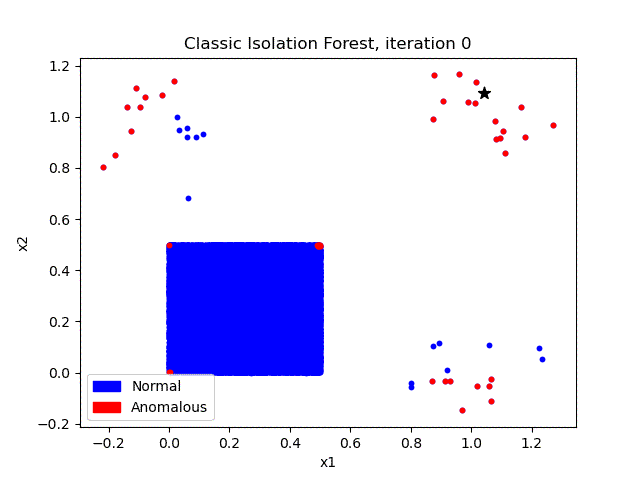

In [69]:
classic_isoforest = ClassicIsoforestAnomalyDetector(n_estimators=100, random_state=0)
classic_experiment = AnomalyDetectionExperiment(regressor=classic_isoforest,
                                     data_features=x, data_labels=x_labels, capacity=100)
classic_experiment.show_cartoon()

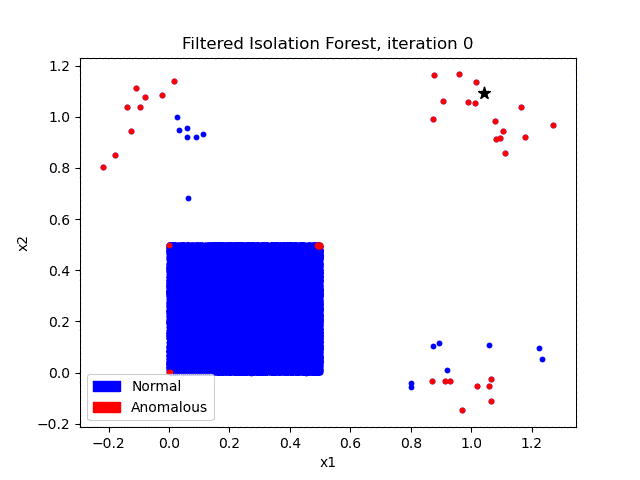

In [68]:
filtered_isoforest = FilteredIsoforestLazyAnomalyDetector(n_estimators=100, n_spares=400, random_state=0)
filtered_experiment = AnomalyDetectionExperiment(regressor=filtered_isoforest,
                                     data_features=x, data_labels=x_labels, capacity=100)
filtered_experiment.show_cartoon()